# Load data from the AVT smart lab

This script should collect the electricity data from 11 sensors of the Technikhaus. The machines include: 
- Th01: Drehmaschine
- Th02:	Drehmaschine
- Th03:	Drehfräse
- Th04:	Fräsmaschine
- Th05:	Drahterodiermaschine
- Th06:	5-Achsen-Fräse
- Th07:	5-Achsen-Fräse
- Th08:	5-Achsen-Fräse
- Th09:	Drehmaschine
- Th10:	Water chiller
- Th11:	Flüssigkeitskühler

Selected measured values are: current, voltage, power, harmonics, etc. 

# ToDo: 
- Sollen die Daten von der IPE Datenbank oder den Sensoren kommen?
- Falls Sensoren: Welche IP-Adressen haben die?

In [1]:
#!pip install influxdb
#!pip install matplotlib

from influxdb import InfluxDBClient
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

In [13]:
# Configuration parameters
host = '141.52.65.181'
port = 8086
dbname = 'iobroker'
user = 'admin'
password = 'Karlsruhe23!'

# Input for time interval
start_datetime = datetime.strptime("2024-03-01 00:00:00", '%Y-%m-%d %H:%M:%S')
end_datetime = datetime.strptime("2024-03-21 23:59:59", '%Y-%m-%d %H:%M:%S')

# Machines and their respective measurements
machines = {
    "th01": "modbus.0.inputRegisters.1.49174_Gesamtwirkleistung",
    "th02": "modbus.1.inputRegisters.1.49174_Gesamtwirkleistung",
    "th03": "modbus.2.inputRegisters.1.49174_Gesamtwirkleistung",
    "th04": "modbus.3.inputRegisters.1.49174_Gesamtwirkleistung",
    "th05": "modbus.4.inputRegisters.1.49174_Gesamtwirkleistung",
    "th06": "modbus.5.inputRegisters.1.49174_Gesamtwirkleistung",
    "th07": "modbus.6.inputRegisters.1.49174_Gesamtwirkleistung",
    "th08": "modbus.7.inputRegisters.1.49174_Gesamtwirkleistung",
    "th09": "modbus.8.inputRegisters.1.49174_Gesamtwirkleistung",
    "th10": "modbus.9.inputRegisters.1.49174_Gesamtwirkleistung",
    "th11": "modbus.10.inputRegisters.1.49174_Gesamtwirkleistung"
}


# Initialize the client and connect to the database
client = InfluxDBClient(host, port, user, password, dbname)

machine_data = {}

# Iterate over machines, execute query, and save data
for machine_name, measurement in machines.items():
    # Adjust the query to dynamically use the provided interval and machine measurement
    query = f'SELECT MEAN("value") AS mean_value FROM "{measurement}" ' \
            f'WHERE time >= \'{start_datetime.strftime("%Y-%m-%d %H:%M:%S")}\' ' \
            f'AND time <= \'{end_datetime.strftime("%Y-%m-%d %H:%M:%S")}\' ' \
            f'GROUP BY time(30m) fill(null)'
    result = client.query(query)
    times = []
    values = []
    for point in result.get_points():
        times.append(datetime.strptime(point['time'], '%Y-%m-%dT%H:%M:%SZ'))  # Convert times to datetime objects
        values.append(point['mean_value'])
    
    # Store data for this machine
    machine_data[machine_name] = {'times': times, 'values': values}

# Close the client
client.close()

In [ ]:
# Plotting
plt.figure(figsize=(15, 5))

# Use fill_between for filling under the line, with a strong yellow color
plt.plot(times, active_power_cleaned_values, marker='o', linestyle='-', markersize=3, color='#fade2a')
plt.fill_between(times, active_power_cleaned_values, color='#fade2a')

plt.title(f'PV - Mean Active Power in 30 minute intervalls')
plt.xlabel('Time')
plt.ylabel('Mean Value')

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Set up the date formatter for the x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

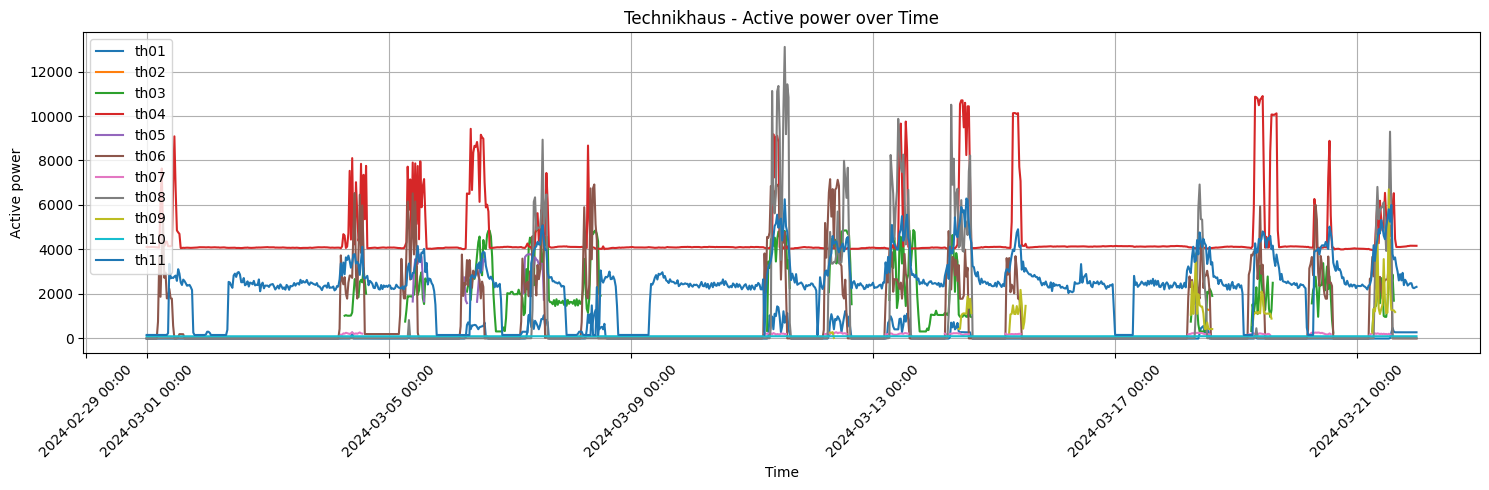

In [22]:
# Plot the data for each machine
plt.figure(figsize=(15, 5))
for machine_name, data in machine_data.items():
    times = data['times']
    values = data['values']
    
    # Plot the data
    plt.plot(times, values, label=machine_name)

# Customize plot
plt.xlabel('Time')
plt.ylabel('Active power')
plt.title('Technikhaus - Active power over Time')

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()